In [1]:
####################################
# Project name: TS Analysis        #      
# Author: Senior developers team   #
# Date: 05.05.2021                 #    
# Institution: Data center         # 
####################################

In [2]:
#Requirements
import os
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf

In [3]:
#We get the data
tickerSymbol = '0ZQ.BE'
tickerData = yf.Ticker(tickerSymbol)
df = tickerData.history(period = "max")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-12-07,9.871312,9.871312,9.871312,9.871312,0,0.0,0
2018-12-10,9.903730,9.903730,9.903730,9.903730,0,0.0,0
2018-12-11,9.814579,9.814579,9.814579,9.814579,0,0.0,0
2018-12-12,9.733535,9.733535,9.733535,9.733535,0,0.0,0
2018-12-13,9.693012,9.693012,9.693012,9.693012,0,0.0,0
...,...,...,...,...,...,...,...
2021-05-06,24.000000,24.500000,23.900000,24.500000,0,0.0,0
2021-05-07,24.000000,25.500000,24.000000,25.000000,0,0.0,0
2021-05-10,25.500000,25.600000,25.400000,25.600000,0,0.0,0


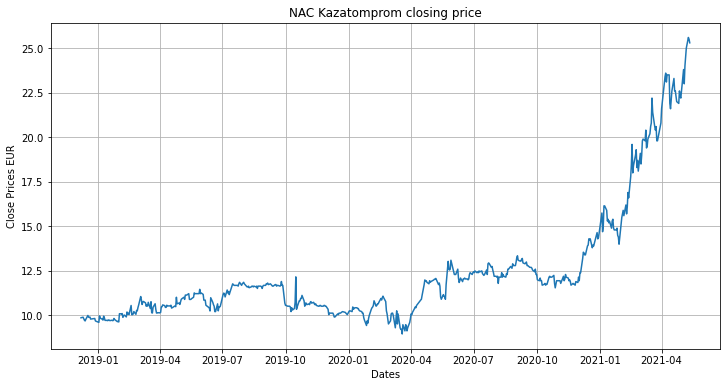

In [4]:
#Let's create a visualization that shows the daily closing price of a stock
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices EUR')
plt.plot(df['Close'])
plt.title('NAC Kazatomprom closing price')
plt.show()

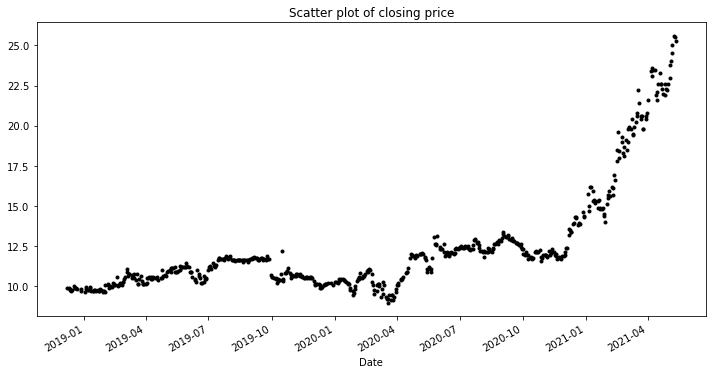

In [5]:
plt.figure(figsize=(12,6))
df_close = df['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

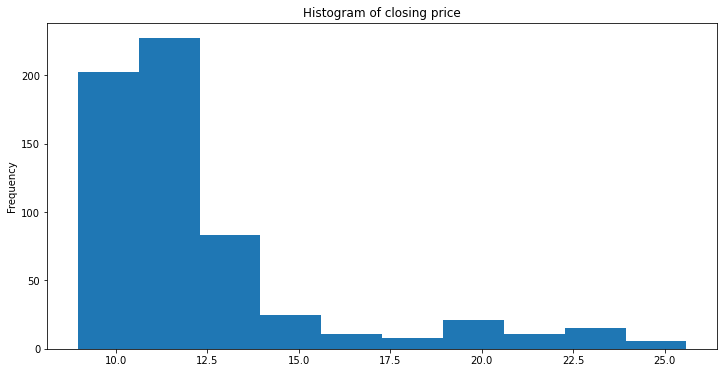

In [6]:
plt.figure(figsize=(12,6))
df_close = df['Close']
df_close.plot(style='k.',kind='hist')
plt.title('Histogram of closing price')
plt.show()

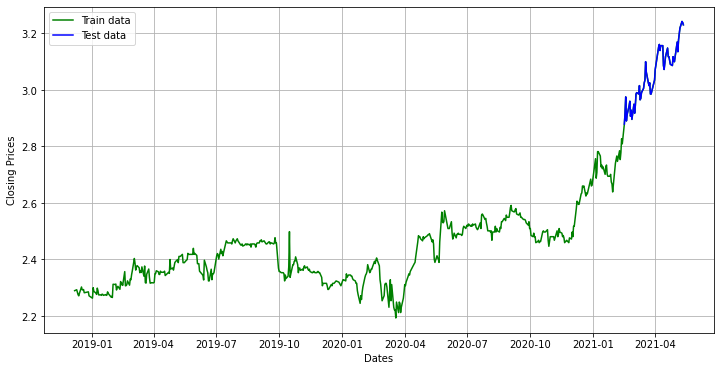

In [10]:
#Divide the data into training and test sets and visualize them
df_log = np.log(df['Close'])
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [11]:
#Stationarity check
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

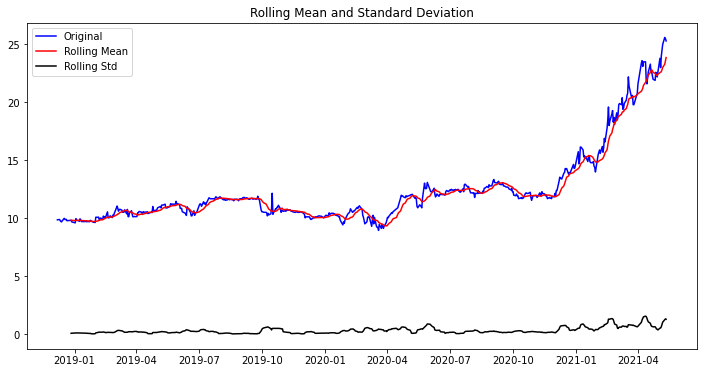

Results of dickey fuller test
Test Statistics                  3.998487
p-value                          1.000000
No. of lags used                17.000000
Number of observations used    591.000000
critical value (1%)             -3.441463
critical value (5%)             -2.866443
critical value (10%)            -2.569381
dtype: float64


In [12]:
test_stationarity(df['Close'])

<Figure size 864x432 with 0 Axes>

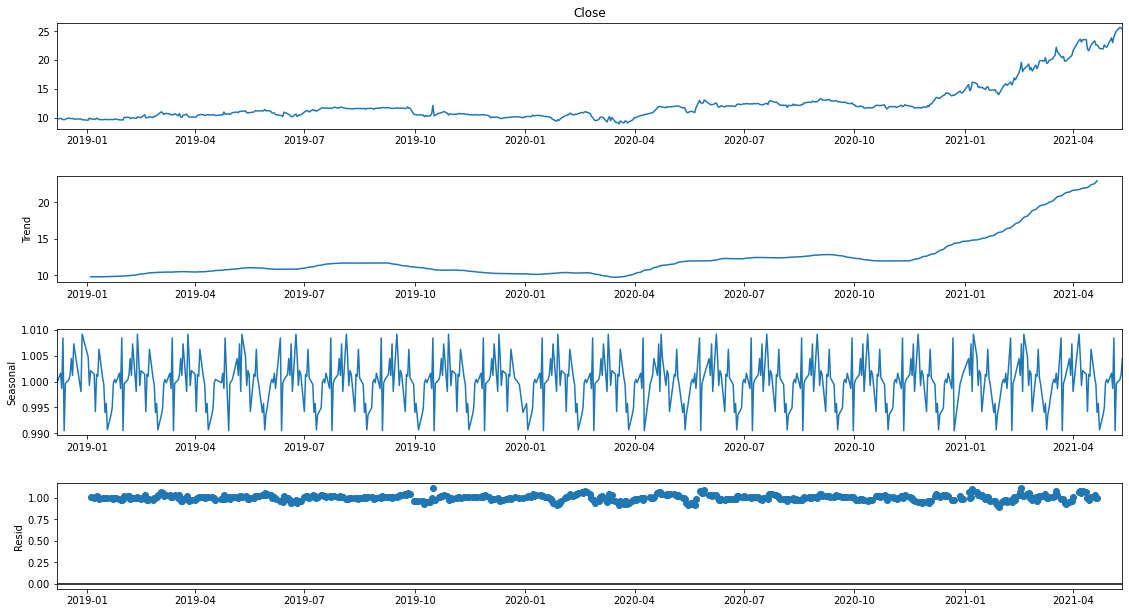

In [13]:
#Separate Trend and Seasonality from the time series
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

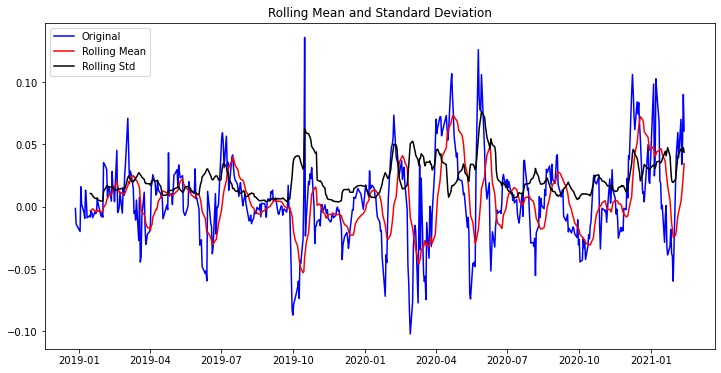

Results of dickey fuller test
Test Statistics               -5.722240e+00
p-value                        6.898652e-07
No. of lags used               1.400000e+01
Number of observations used    5.220000e+02
critical value (1%)           -3.442940e+00
critical value (5%)           -2.867093e+00
critical value (10%)          -2.569727e+00
dtype: float64


In [14]:
#Removing Trend
moving_avg = df_log.rolling(12).mean()
train_log_moving_avg_diff = train_data - moving_avg
train_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(train_log_moving_avg_diff)

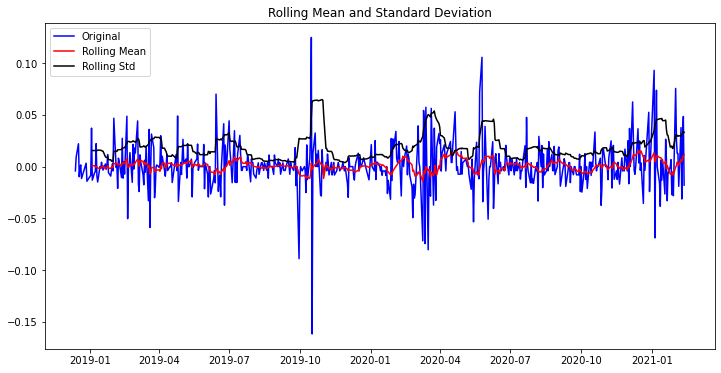

Results of dickey fuller test
Test Statistics                -19.321473
p-value                          0.000000
No. of lags used                 1.000000
Number of observations used    542.000000
critical value (1%)             -3.442473
critical value (5%)             -2.866887
critical value (10%)            -2.569618
dtype: float64


In [15]:
#Differencing
train_log_diff = train_data - train_data.shift(1) 
test_stationarity(train_log_diff.dropna())

In [16]:
#AUTO_ARIMA
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
test='adf',       # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # No Seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2586.660, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2607.722, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2609.909, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2587.615, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2607.926, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2608.013, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2606.343, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2610.104, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2608.105, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2608.170, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2608.122, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2606.460, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.838 seconds
                               SARIMAX Results                              

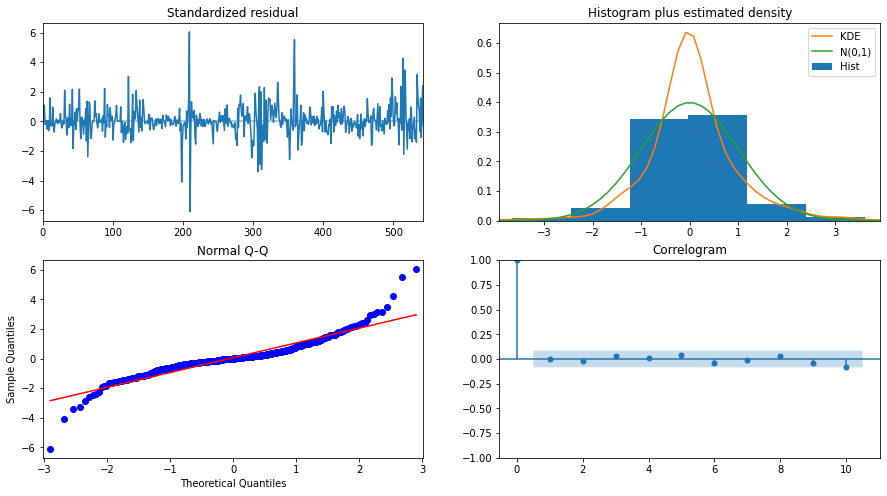

In [17]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [19]:
#ARIMA MODEL
model = ARIMA(train_data, order=(0, 1, 1))
fitted = model.fit(disp=-1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  544
Model:                 ARIMA(0, 1, 1)   Log Likelihood                1307.956
Method:                       css-mle   S.D. of innovations              0.022
Date:                Wed, 12 May 2021   AIC                          -2609.913
Time:                        23:08:27   BIC                          -2597.016
Sample:                             1   HQIC                         -2604.870
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0010      0.001      1.349      0.177      -0.000       0.002
ma.L1.D.Close    -0.2208      0.042     -5.257      0.000      -0.303      -0.138
                                    Root

/Users/jeugheung/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/jeugheung/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [20]:
#Forecast
fc, se, conf = fitted.forecast(61, alpha=0.05)

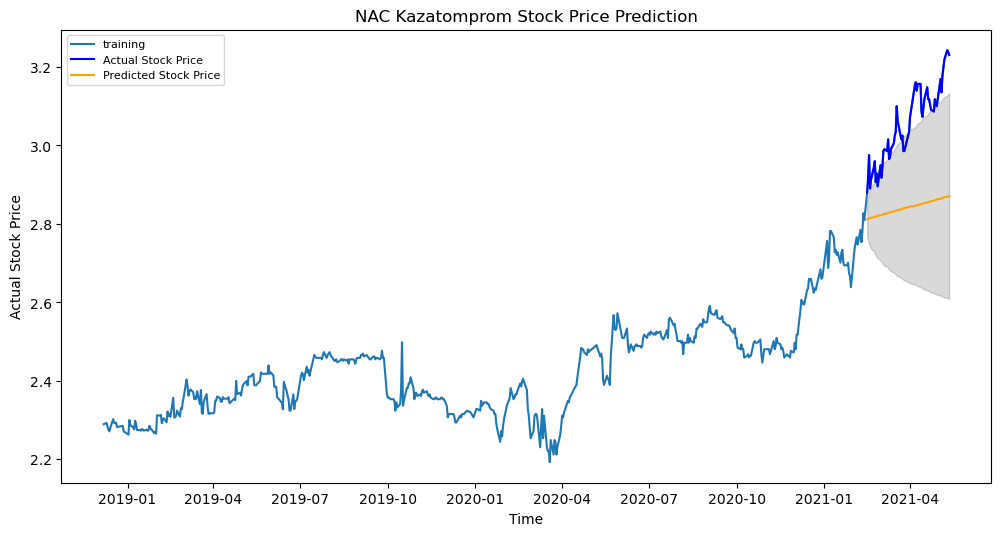

In [21]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,6), dpi=100)
plt.plot(df_log, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('NAC Kazatomprom Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [22]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.050873217534357015
MAE: 0.21090209711068786
RMSE: 0.22555092004768462
MAPE: 0.06834260957199971


In [24]:
#Improve our model
model = ARIMA(train_data, order=(1, 2, 3))
fitted = model.fit(disp=-1)
print(fitted.summary())

/Users/jeugheung/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/jeugheung/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  543
Model:                 ARIMA(1, 2, 3)   Log Likelihood                1302.666
Method:                       css-mle   S.D. of innovations              0.022
Date:                Wed, 12 May 2021   AIC                          -2593.332
Time:                        23:11:56   BIC                          -2567.549
Sample:                             2   HQIC                         -2583.250
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.593e-06   4.67e-06      0.984      0.325   -4.55e-06    1.37e-05
ar.L1.D2.Close    -0.8999      0.192     -4.688      0.000      -1.276      -0.524
ma.L1.D2.Close    -0.3072      0.194

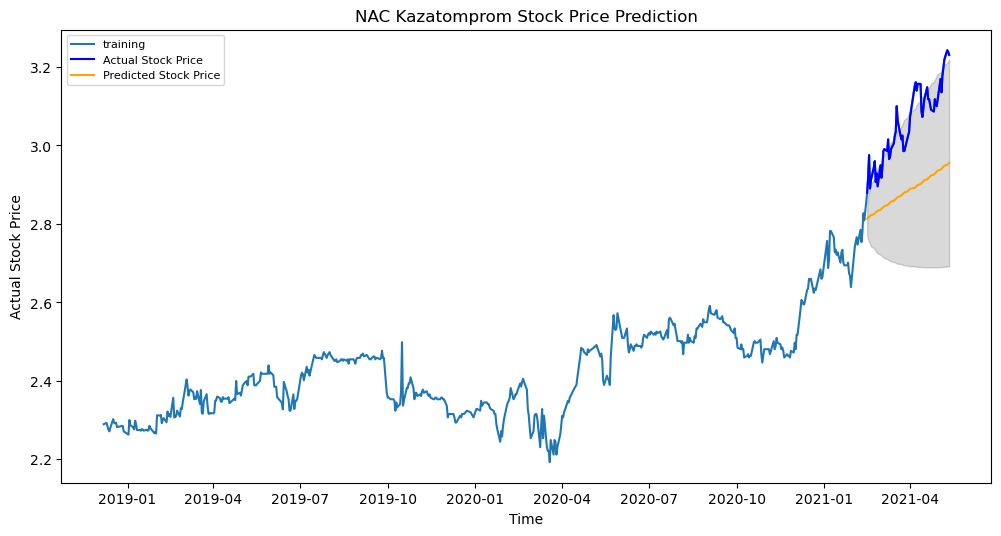

In [25]:
#Forecast
fc, se, conf = fitted.forecast(61, alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,6), dpi=100)
plt.plot(df_log, color = 'blue'label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('NAC Kazatomprom Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [26]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.03216750007069955
MAE: 0.16919728101849305
RMSE: 0.17935300407492358
MAPE: 0.0548973873946304
